# Transfer learning

In [5]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<img src="data/Cats-Dogs-Rex.jpg" alt="Drawing" style="height: 450px;" align="center"/>

#### The Dogs vs Cats dataset

[Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data)

#### Load and preprocess the data

In [2]:
images_train = np.load('data/images_train.npy') / 255.
images_valid = np.load('data/images_valid.npy') / 255.
images_test = np.load('data/images_test.npy') / 255.

labels_train = np.load('data/labels_train.npy')
labels_valid = np.load('data/labels_valid.npy')
labels_test = np.load('data/labels_test.npy')

In [3]:
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


#### Display sample images and labels from the training set

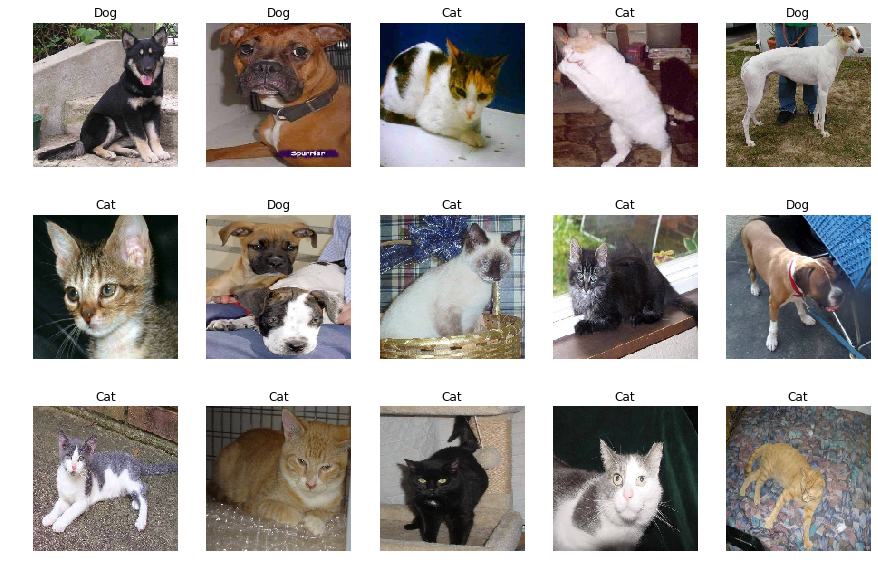

In [4]:
# Display a few images and labels

class_names = np.array(['Dog', 'Cat'])

plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

#### Create a benchmark model

* The model should use the `input_shape` in the function argument to set the shape in the Input layer.
* The first and second hidden layers should be Conv2D layers with 32 filters, 3x3 kernel size and ReLU activation.
* The third hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The fourth and fifth hidden layers should be Conv2D layers with 64 filters, 3x3 kernel size and ReLU activation.
* The sixth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The seventh and eighth hidden layers should be Conv2D layers with 128 filters, 3x3 kernel size and ReLU activation.
* The ninth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* This should be followed by a Flatten layer, and a Dense layer with 128 units and ReLU activation
* The final layer should be a Dense layer with a single neuron and sigmoid activation.
* All of the Conv2D layers should use `'SAME'` padding.

In [1]:
def get_benchmark_model(input_shape):
    """
    This function should build and compile a CNN model according to the above specification,
    using the functional API. The function takes input_shape as an argument, which should be
    used to specify the shape in the Input layer.
    Your function should return the model.
    """
    inputs = keras.Input(shape = input_shape)
    x = layers.Conv2D(32, (3,3), activation ='relu', padding = 'SAME')(inputs)
    x = layers.Conv2D(32, (3,3), activation ='relu', padding = 'SAME')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, (3,3), activation ='relu', padding = 'SAME')(x)
    x = layers.Conv2D(64, (3,3), activation ='relu', padding = 'SAME')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, (3,3), activation ='relu', padding = 'SAME')(x)
    x = layers.Conv2D(128, (3,3), activation ='relu', padding = 'SAME')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name = 'CNN_Model')
    
    model.compile(optimzer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    
    return model

In [7]:
# Build and compile the benchmark model, and display the model summary

benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary()

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0 

#### Train the CNN benchmark model

We will train the benchmark CNN model using an `EarlyStopping` callback. Feel free to increase the training time if you wish.

In [8]:
# Fit the benchmark model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                        validation_data=(images_valid, labels_valid), 
                                        callbacks=[earlystopping])

Train on 600 samples, validate on 300 samples
Epoch 1/10
600/600 [==============================] - 505s 842ms/sample - loss: 1.2142 - binary_accuracy: 0.5000 - val_loss: 0.6914 - val_binary_accuracy: 0.5633
Epoch 2/10
600/600 [==============================] - 469s 782ms/sample - loss: 0.6968 - binary_accuracy: 0.4833 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 3/10
600/600 [==============================] - 462s 770ms/sample - loss: 0.6968 - binary_accuracy: 0.5217 - val_loss: 0.6888 - val_binary_accuracy: 0.5533
Epoch 4/10
600/600 [==============================] - 482s 803ms/sample - loss: 0.6868 - binary_accuracy: 0.5500 - val_loss: 0.6845 - val_binary_accuracy: 0.5667
Epoch 5/10
600/600 [==============================] - 473s 789ms/sample - loss: 0.6848 - binary_accuracy: 0.5550 - val_loss: 0.7345 - val_binary_accuracy: 0.5000
Epoch 6/10
600/600 [==============================] - 471s 785ms/sample - loss: 0.6831 - binary_accuracy: 0.5750 - val_loss: 0.7161 - val_binary

#### Plot the learning curves

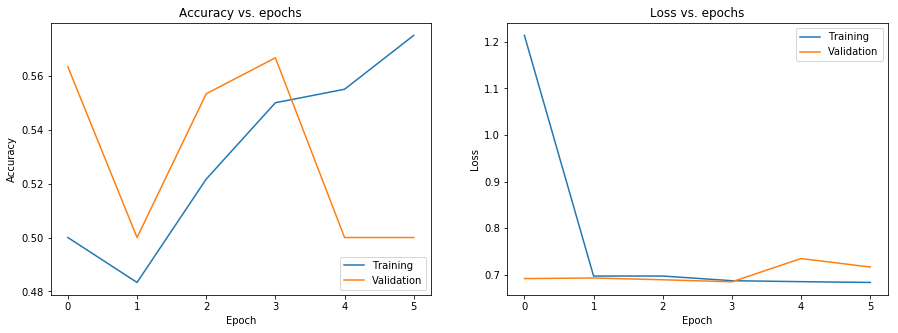

In [10]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_benchmark.history['accuracy'])
    plt.plot(history_benchmark.history['val_accuracy'])
except KeyError:
    plt.plot(history_benchmark.history['binary_accuracy'])
    plt.plot(history_benchmark.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the benchmark model

In [11]:
# Evaluate the benchmark model on the test set

benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 0.7317942492167155
Test accuracy: 0.5066666603088379


#### Load the pretrained image classifier model

[Keras Applications](https://keras.io/applications/#mobilenetv2).

In [2]:

def load_pretrained_MobileNetV2(path):
    """
    This function takes a path as an argument, and uses it to 
    load the full MobileNetV2 pretrained model from the path.
    Your function should return the loaded model.
    """
    model = keras.models.load_model(path)
    return model

In [13]:
# Call the function loading the pretrained model and display its summary

base_model = load_pretrained_MobileNetV2('models/MobileNetV2.h5')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Use the pre-trained model as a feature extractor

In [22]:
def remove_head(pretrained_model):
    """
    This function should create and return a new model, using the input and output 
    tensors as specified above. 
    Use the 'get_layer' method to access the correct layer of the pre-trained model.
    """
    new_input = pretrained_model.input
    new_output = pretrained_model.layers[-2].output    
    model = keras.Model(inputs=new_input, outputs=new_output)
    return model
    

In [23]:
# Call the function removing the classification head and display the summary

feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

You can now construct new final classifier layers for your model. Using the Sequential API, create a new model according to the following specifications:

* The new model should begin with the feature extractor model.
* This should then be followed with a new dense layer with 32 units and ReLU activation function.
* This should be followed by a dropout layer with a rate of 0.5.
* Finally, this should be followed by a Dense layer with a single neuron and a sigmoid activation function.

In total, the network should be composed of the pretrained base model plus 3 layers.

In [3]:
def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument, and should create
    and return a new model according to the above specification.
    """
    model = keras.Sequential([
        feature_extractor_model,
        layers.Dense(32, activation='relu'),
        layers.Dropout(.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model
    

In [35]:
# Call the function adding a new classification head and display the summary

new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 2,264,897
Non-trainable params: 34,112
_________________________________________________________________


#### Freeze the weights of the pretrained model

In [41]:
def freeze_pretrained_weights(model):
    """
    This function should freeze the weights of the pretrained base model.
    Your function should return the model with frozen weights.
    """
    model.layers[0].trainable = False
    model.compile(optimizer = 'RMSProp', loss = 'binary_crossentropy', metrics =['binary_accuracy'] )
    return model
    

In [42]:
# Call the function freezing the pretrained weights and display the summary

frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the model

You are now ready to train the new model on the dogs vs cats data subset. We will use an `EarlyStopping` callback with patience set to 2 epochs, as before. Feel free to increase the training time if you wish.

In [43]:
# Train the model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid, labels_valid), 
                                                callbacks=[earlystopping])

Train on 600 samples, validate on 300 samples
Epoch 1/10
600/600 [==============================] - 258s 430ms/sample - loss: 0.5351 - binary_accuracy: 0.7283 - val_loss: 0.2427 - val_binary_accuracy: 0.8933
Epoch 2/10
600/600 [==============================] - 209s 348ms/sample - loss: 0.3034 - binary_accuracy: 0.8800 - val_loss: 0.1915 - val_binary_accuracy: 0.9100
Epoch 3/10
600/600 [==============================] - 191s 318ms/sample - loss: 0.2207 - binary_accuracy: 0.8950 - val_loss: 0.2172 - val_binary_accuracy: 0.9167
Epoch 4/10
600/600 [==============================] - 205s 342ms/sample - loss: 0.2627 - binary_accuracy: 0.8850 - val_loss: 0.1419 - val_binary_accuracy: 0.9500
Epoch 5/10
600/600 [==============================] - 204s 340ms/sample - loss: 0.1590 - binary_accuracy: 0.9433 - val_loss: 0.2317 - val_binary_accuracy: 0.9233
Epoch 6/10
600/600 [==============================] - 209s 349ms/sample - loss: 0.1467 - binary_accuracy: 0.9433 - val_loss: 0.2974 - val_binary

#### Plot the learning curves

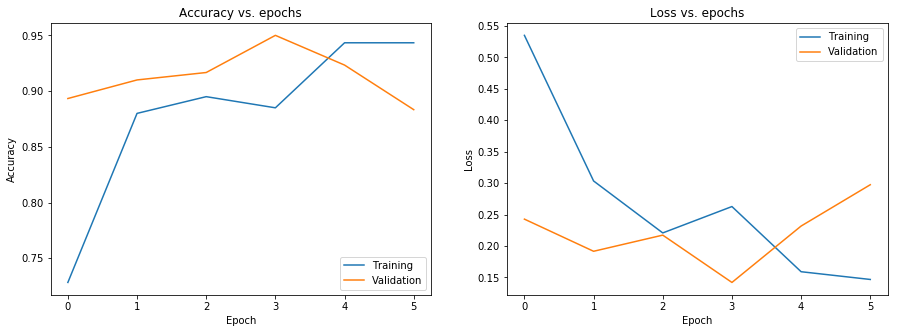

In [44]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_frozen_new_model.history['binary_accuracy'])
    plt.plot(history_frozen_new_model.history['val_binary_accuracy'])
except KeyError:
    plt.plot(history_frozen_new_model.history['acc'])
    plt.plot(history_frozen_new_model.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the new model

In [45]:
# Evaluate the benchmark model on the test set

new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(new_model_test_loss))
print("Test accuracy: {}".format(new_model_test_acc))

Test loss: 0.2515357025464376
Test accuracy: 0.8966666460037231


#### Compare both models
comparison of training, validation and test metrics between the benchmark and transfer learning model.

In [46]:
# Gather the benchmark and new model metrics

benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]

benchmark_train_acc = history_benchmark.history['binary_accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_binary_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]

new_model_train_acc = history_frozen_new_model.history['binary_accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_binary_accuracy'][-1]

In [47]:
# Compile the metrics into a pandas DataFrame and display the table

comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, new_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
                                ['Test loss', benchmark_test_loss, new_model_test_loss],
                                ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
,Training loss,0.683063,0.146685
,Training accuracy,0.575000,0.943333
,Validation loss,0.716116,0.297437
,Validation accuracy,0.500000,0.883333
,Test loss,0.731794,0.251536
,Test accuracy,0.506667,0.896667


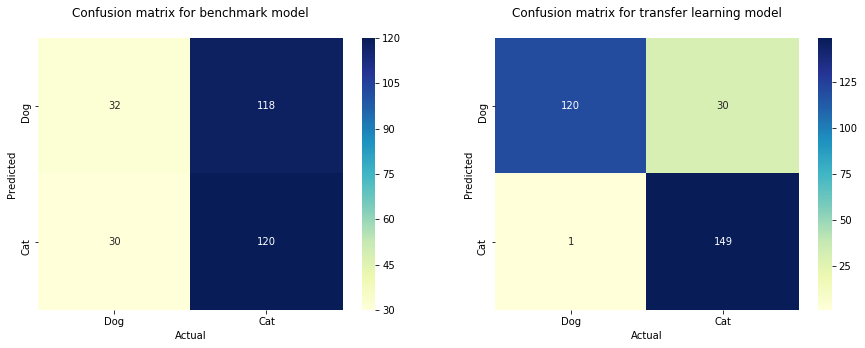

In [48]:
# Plot confusion matrices for benchmark and transfer learning models

plt.figure(figsize=(15, 5))

preds = benchmark_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(121)
plt.title("Confusion matrix for benchmark model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

preds = frozen_new_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

Congratulations for completing this programming assignment! In the next week of the course we will learn how to develop an effective data pipeline.